## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp008'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    #backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnet152'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

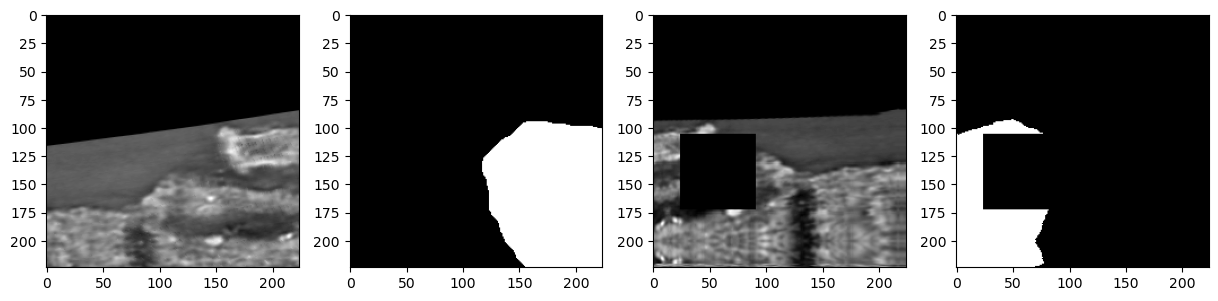

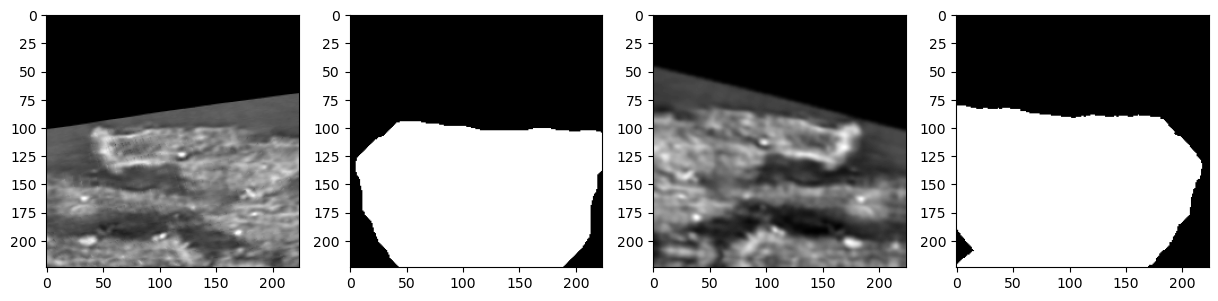

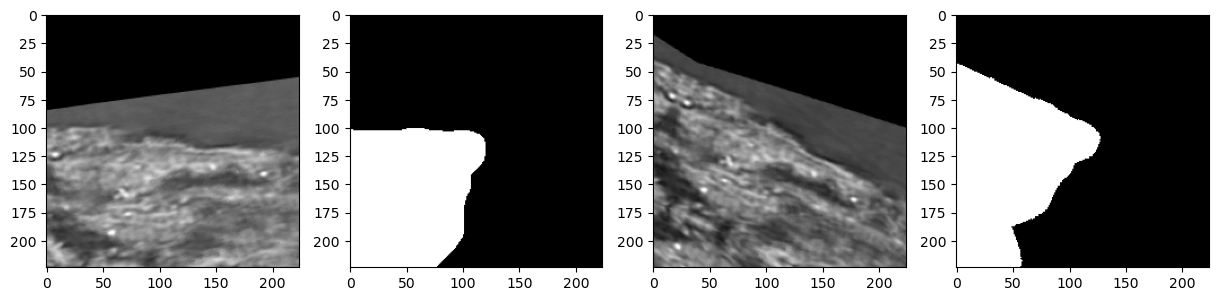

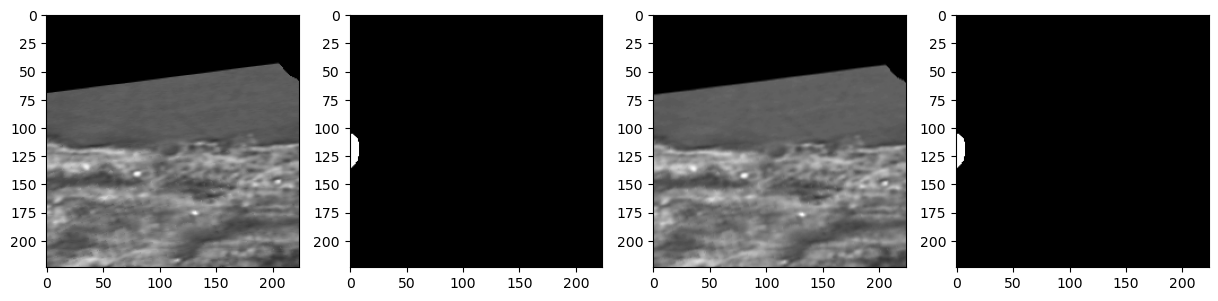

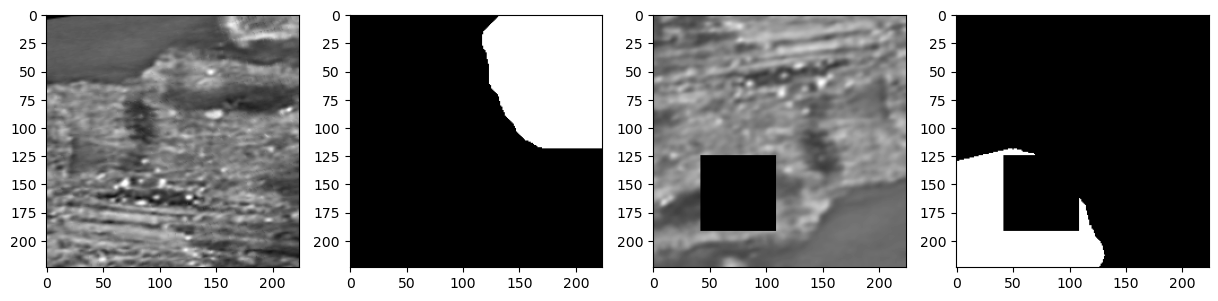

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnet152


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14208833843217625
th: 0.15, fbeta: 0.14207100405218118
th: 0.2, fbeta: 0.1420124405200767
th: 0.25, fbeta: 0.1418602232369635
th: 0.3, fbeta: 0.1781835040498668
th: 0.35, fbeta: 0.19741981616338655
th: 0.4, fbeta: 0.20688765755695712
th: 0.45, fbeta: 0.2161167991277392


best_th: 0.5, fbeta: 0.22457627044416523
Epoch 1 - avg_train_loss: 0.7414  avg_val_loss: 0.5747  time: 184s
Epoch 1 - avgScore: 0.2246
Epoch 1 - Save Best Score: 0.2246 Model
Epoch 1 - Save Best Loss: 0.5747 Model


th: 0.5, fbeta: 0.22457627044416523


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209050124002962
th: 0.15, fbeta: 0.14206722482144868
th: 0.2, fbeta: 0.14411097109399829
th: 0.25, fbeta: 0.19468896426924692
th: 0.3, fbeta: 0.20642064139876365
th: 0.35, fbeta: 0.21233084204186295
th: 0.4, fbeta: 0.22244618963013996
th: 0.45, fbeta: 0.20490486532581859


best_th: 0.4, fbeta: 0.22244618963013996
Epoch 2 - avg_train_loss: 0.4932  avg_val_loss: 0.4647  time: 187s
Epoch 2 - avgScore: 0.2224


th: 0.5, fbeta: 0.14523162101505904


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.27988787440174906
th: 0.15, fbeta: 0.1429823199147217
th: 0.2, fbeta: 0.0762158071210136
th: 0.25, fbeta: 0.04561639182347459
th: 0.3, fbeta: 0.030885440225503623
th: 0.35, fbeta: 0.021880275674876826
th: 0.4, fbeta: 0.01455699134591562
th: 0.45, fbeta: 0.009202776189106834


best_th: 0.1, fbeta: 0.27988787440174906
Epoch 3 - avg_train_loss: 0.2764  avg_val_loss: 0.4099  time: 184s
Epoch 3 - avgScore: 0.2799
Epoch 3 - Save Best Score: 0.2799 Model
Epoch 3 - Save Best Loss: 0.4099 Model


th: 0.5, fbeta: 0.005230291021246047


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3869307960269451
th: 0.15, fbeta: 0.3083608584047344
th: 0.2, fbeta: 0.19811294885325417
th: 0.25, fbeta: 0.11610406643609372
th: 0.3, fbeta: 0.06889328530333103
th: 0.35, fbeta: 0.04295908522176784
th: 0.4, fbeta: 0.02754119138121837
th: 0.45, fbeta: 0.01837827265183309


best_th: 0.1, fbeta: 0.3869307960269451
Epoch 4 - avg_train_loss: 0.2016  avg_val_loss: 0.3745  time: 187s
Epoch 4 - avgScore: 0.3869
Epoch 4 - Save Best Score: 0.3869 Model
Epoch 4 - Save Best Loss: 0.3745 Model


th: 0.5, fbeta: 0.012775157179926104


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3582043962105593
th: 0.15, fbeta: 0.4014222189834023
th: 0.2, fbeta: 0.40863313490046527
th: 0.25, fbeta: 0.38190641307254625
th: 0.3, fbeta: 0.3362616373504619
th: 0.35, fbeta: 0.28854055125750644
th: 0.4, fbeta: 0.23939284076967945
th: 0.45, fbeta: 0.19067479594730394


best_th: 0.2, fbeta: 0.40863313490046527
Epoch 5 - avg_train_loss: 0.1948  avg_val_loss: 0.3544  time: 184s
Epoch 5 - avgScore: 0.4086
Epoch 5 - Save Best Score: 0.4086 Model
Epoch 5 - Save Best Loss: 0.3544 Model


th: 0.5, fbeta: 0.14578253261167354


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3787886774075275
th: 0.15, fbeta: 0.32453474739964916
th: 0.2, fbeta: 0.2483796233775677
th: 0.25, fbeta: 0.17639599341241724
th: 0.3, fbeta: 0.12462065839362094
th: 0.35, fbeta: 0.0901397408879531
th: 0.4, fbeta: 0.06421552957257075
th: 0.45, fbeta: 0.042621986089504744


best_th: 0.1, fbeta: 0.3787886774075275
Epoch 6 - avg_train_loss: 0.1902  avg_val_loss: 0.4207  time: 184s
Epoch 6 - avgScore: 0.3788


th: 0.5, fbeta: 0.0295372884737925


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36458404018219626
th: 0.15, fbeta: 0.27964814388893855
th: 0.2, fbeta: 0.19795226624254367
th: 0.25, fbeta: 0.1328137265787447
th: 0.3, fbeta: 0.09061254992521867
th: 0.35, fbeta: 0.06138725605196798
th: 0.4, fbeta: 0.04107423149247803
th: 0.45, fbeta: 0.025894356478034317


best_th: 0.1, fbeta: 0.36458404018219626
Epoch 7 - avg_train_loss: 0.1837  avg_val_loss: 0.4328  time: 183s
Epoch 7 - avgScore: 0.3646


th: 0.5, fbeta: 0.016812359100307546


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.13178023192533544
th: 0.15, fbeta: 0.057426963993764006
th: 0.2, fbeta: 0.02876145583665704
th: 0.25, fbeta: 0.018090373247293873
th: 0.3, fbeta: 0.012181226373434642
th: 0.35, fbeta: 0.008819716931332973
th: 0.4, fbeta: 0.006786196022940599
th: 0.45, fbeta: 0.005596979888906943


best_th: 0.1, fbeta: 0.13178023192533544
Epoch 8 - avg_train_loss: 0.1819  avg_val_loss: 0.5170  time: 186s
Epoch 8 - avgScore: 0.1318


th: 0.5, fbeta: 0.004836662543169769


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42633469393400103
th: 0.15, fbeta: 0.4109542632659514
th: 0.2, fbeta: 0.360515472977372
th: 0.25, fbeta: 0.29628912826509096
th: 0.3, fbeta: 0.236637494529212
th: 0.35, fbeta: 0.18303648620022475
th: 0.4, fbeta: 0.13802176823398102
th: 0.45, fbeta: 0.10254104401745623


best_th: 0.1, fbeta: 0.42633469393400103
Epoch 9 - avg_train_loss: 0.1725  avg_val_loss: 0.4174  time: 183s
Epoch 9 - avgScore: 0.4263
Epoch 9 - Save Best Score: 0.4263 Model
Epoch 9 - Save Best Loss: 0.4174 Model


th: 0.5, fbeta: 0.07575102840642876


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40250370212524844
th: 0.15, fbeta: 0.4258776034775336
th: 0.2, fbeta: 0.43093295863159803
th: 0.25, fbeta: 0.42219153028249906
th: 0.3, fbeta: 0.4008555573726618
th: 0.35, fbeta: 0.3693507717974455
th: 0.4, fbeta: 0.326257982841673
th: 0.45, fbeta: 0.2795483227124402


best_th: 0.2, fbeta: 0.43093295863159803
Epoch 10 - avg_train_loss: 0.1723  avg_val_loss: 0.3819  time: 185s
Epoch 10 - avgScore: 0.4309
Epoch 10 - Save Best Score: 0.4309 Model
Epoch 10 - Save Best Loss: 0.3819 Model


th: 0.5, fbeta: 0.23045007711763063


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36915581998244756
th: 0.15, fbeta: 0.3336050099675862
th: 0.2, fbeta: 0.28404821695360016
th: 0.25, fbeta: 0.24013265023089667
th: 0.3, fbeta: 0.1976063285263737
th: 0.35, fbeta: 0.15870010721303443
th: 0.4, fbeta: 0.12160628277310846
th: 0.45, fbeta: 0.0944127350541945


best_th: 0.1, fbeta: 0.36915581998244756
Epoch 11 - avg_train_loss: 0.1677  avg_val_loss: 0.4753  time: 185s
Epoch 11 - avgScore: 0.3692


th: 0.5, fbeta: 0.07288401381942176


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3769213839648518
th: 0.15, fbeta: 0.38331916354421486
th: 0.2, fbeta: 0.3748609533109007
th: 0.25, fbeta: 0.34714894791606526
th: 0.3, fbeta: 0.3081549979877582
th: 0.35, fbeta: 0.2681829666518947
th: 0.4, fbeta: 0.2257850108112351
th: 0.45, fbeta: 0.18485860765319684


best_th: 0.15, fbeta: 0.38331916354421486
Epoch 12 - avg_train_loss: 0.1657  avg_val_loss: 0.4409  time: 185s
Epoch 12 - avgScore: 0.3833


th: 0.5, fbeta: 0.14934446297919804


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3269526998513224
th: 0.15, fbeta: 0.2982170427913173
th: 0.2, fbeta: 0.2645099853537132
th: 0.25, fbeta: 0.22822882529771998
th: 0.3, fbeta: 0.18707614567167027
th: 0.35, fbeta: 0.14812549511763978
th: 0.4, fbeta: 0.11433681078524945
th: 0.45, fbeta: 0.08630535913227336


best_th: 0.1, fbeta: 0.3269526998513224
Epoch 13 - avg_train_loss: 0.1577  avg_val_loss: 0.4865  time: 184s
Epoch 13 - avgScore: 0.3270


th: 0.5, fbeta: 0.06351196742753448


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3938725732065798
th: 0.15, fbeta: 0.38276961939818477
th: 0.2, fbeta: 0.362243779307821
th: 0.25, fbeta: 0.3375643887903035
th: 0.3, fbeta: 0.3112119866753961
th: 0.35, fbeta: 0.28240998779584
th: 0.4, fbeta: 0.24951651671405342
th: 0.45, fbeta: 0.21630931455576902


best_th: 0.1, fbeta: 0.3938725732065798
Epoch 14 - avg_train_loss: 0.1538  avg_val_loss: 0.4786  time: 184s
Epoch 14 - avgScore: 0.3939


th: 0.5, fbeta: 0.18519788282115274


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30372642605914085
th: 0.15, fbeta: 0.2684901964547054
th: 0.2, fbeta: 0.23457020379173177
th: 0.25, fbeta: 0.2005572964703256
th: 0.3, fbeta: 0.16998183022587784
th: 0.35, fbeta: 0.14283461010908105
th: 0.4, fbeta: 0.11880266288744792
th: 0.45, fbeta: 0.09950609646226558


best_th: 0.1, fbeta: 0.30372642605914085
Epoch 15 - avg_train_loss: 0.1488  avg_val_loss: 0.4838  time: 184s
Epoch 15 - avgScore: 0.3037


th: 0.5, fbeta: 0.08300932751052387


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3871019893756455
th: 0.15, fbeta: 0.3399029421449195
th: 0.2, fbeta: 0.2835068121075025
th: 0.25, fbeta: 0.23708064934564957
th: 0.3, fbeta: 0.19568940119778136
th: 0.35, fbeta: 0.15772692453740053
th: 0.4, fbeta: 0.12340160317749486
th: 0.45, fbeta: 0.09421223069366352


best_th: 0.1, fbeta: 0.3871019893756455
Epoch 16 - avg_train_loss: 0.1461  avg_val_loss: 0.4928  time: 184s
Epoch 16 - avgScore: 0.3871


th: 0.5, fbeta: 0.06913632147041042


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3860022359802083
th: 0.15, fbeta: 0.36639343269863756
th: 0.2, fbeta: 0.32565268332093966
th: 0.25, fbeta: 0.2776525524345086
th: 0.3, fbeta: 0.22860218019512438
th: 0.35, fbeta: 0.18364065362836776
th: 0.4, fbeta: 0.14324870088741018
th: 0.45, fbeta: 0.10811044038861531


best_th: 0.1, fbeta: 0.3860022359802083
Epoch 17 - avg_train_loss: 0.1392  avg_val_loss: 0.5139  time: 184s
Epoch 17 - avgScore: 0.3860


th: 0.5, fbeta: 0.08001017421369484


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3670690967912515
th: 0.15, fbeta: 0.3224408592639507
th: 0.2, fbeta: 0.2735420850050373
th: 0.25, fbeta: 0.23065929362261864
th: 0.3, fbeta: 0.19396771367057541
th: 0.35, fbeta: 0.16270159000913903
th: 0.4, fbeta: 0.13632536508047974
th: 0.45, fbeta: 0.11151187838700824


best_th: 0.1, fbeta: 0.3670690967912515
Epoch 18 - avg_train_loss: 0.1344  avg_val_loss: 0.5488  time: 187s
Epoch 18 - avgScore: 0.3671


th: 0.5, fbeta: 0.08720190338255014


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38522564855123925
th: 0.15, fbeta: 0.36414130170510806
th: 0.2, fbeta: 0.3392000202218011
th: 0.25, fbeta: 0.3124207518999105
th: 0.3, fbeta: 0.28555440103125557
th: 0.35, fbeta: 0.2554597138632878
th: 0.4, fbeta: 0.22312255921606747
th: 0.45, fbeta: 0.18891748044990236


best_th: 0.1, fbeta: 0.38522564855123925
Epoch 19 - avg_train_loss: 0.1303  avg_val_loss: 0.5061  time: 186s
Epoch 19 - avgScore: 0.3852


th: 0.5, fbeta: 0.156449489625244


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3691673380682316
th: 0.15, fbeta: 0.3675604906794474
th: 0.2, fbeta: 0.3537452271480701
th: 0.25, fbeta: 0.33269197806924045
th: 0.3, fbeta: 0.3038443982065303
th: 0.35, fbeta: 0.2712932415748175
th: 0.4, fbeta: 0.23552207102660436
th: 0.45, fbeta: 0.19952280182089643


best_th: 0.1, fbeta: 0.3691673380682316
Epoch 20 - avg_train_loss: 0.1239  avg_val_loss: 0.4918  time: 184s
Epoch 20 - avgScore: 0.3692


th: 0.5, fbeta: 0.16640796015750833


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3529006512859659
th: 0.15, fbeta: 0.33642484692466396
th: 0.2, fbeta: 0.31547216540985384
th: 0.25, fbeta: 0.29125145345233544
th: 0.3, fbeta: 0.261812484999756
th: 0.35, fbeta: 0.23068472046652885
th: 0.4, fbeta: 0.1971511312575234
th: 0.45, fbeta: 0.16439548208096993


best_th: 0.1, fbeta: 0.3529006512859659
Epoch 21 - avg_train_loss: 0.1191  avg_val_loss: 0.5565  time: 185s
Epoch 21 - avgScore: 0.3529


th: 0.5, fbeta: 0.134508240473343


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33956984701432086
th: 0.15, fbeta: 0.325374952240287
th: 0.2, fbeta: 0.30755840622717395
th: 0.25, fbeta: 0.2865208288583744
th: 0.3, fbeta: 0.2655917814476885
th: 0.35, fbeta: 0.240612648654392
th: 0.4, fbeta: 0.2148560297750148
th: 0.45, fbeta: 0.19037244605418682


best_th: 0.1, fbeta: 0.33956984701432086
Epoch 22 - avg_train_loss: 0.1138  avg_val_loss: 0.5608  time: 184s
Epoch 22 - avgScore: 0.3396


th: 0.5, fbeta: 0.16801309838330003


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.324613360095471
th: 0.15, fbeta: 0.29621284934936587
th: 0.2, fbeta: 0.26570052811310846
th: 0.25, fbeta: 0.2388205953574496
th: 0.3, fbeta: 0.21148890446088386
th: 0.35, fbeta: 0.1859856982809081
th: 0.4, fbeta: 0.16198703789614946
th: 0.45, fbeta: 0.13802463791297076


best_th: 0.1, fbeta: 0.324613360095471
Epoch 23 - avg_train_loss: 0.1116  avg_val_loss: 0.5637  time: 186s
Epoch 23 - avgScore: 0.3246


th: 0.5, fbeta: 0.11667281926073764


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35074674615452683
th: 0.15, fbeta: 0.3347629309071334
th: 0.2, fbeta: 0.3116488622415456
th: 0.25, fbeta: 0.28055683607000165
th: 0.3, fbeta: 0.24683195047882403
th: 0.35, fbeta: 0.21399429736669554
th: 0.4, fbeta: 0.1825571803455169
th: 0.45, fbeta: 0.1549183228223701


best_th: 0.1, fbeta: 0.35074674615452683
Epoch 24 - avg_train_loss: 0.1077  avg_val_loss: 0.5648  time: 184s
Epoch 24 - avgScore: 0.3507


th: 0.5, fbeta: 0.12813913909231023


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3325256036523525
th: 0.15, fbeta: 0.32196065181382605
th: 0.2, fbeta: 0.3084658455421383
th: 0.25, fbeta: 0.2886907653652778
th: 0.3, fbeta: 0.2647003246785297
th: 0.35, fbeta: 0.23906342928913943
th: 0.4, fbeta: 0.21406620646415983
th: 0.45, fbeta: 0.1888577277066275


best_th: 0.1, fbeta: 0.3325256036523525
Epoch 25 - avg_train_loss: 0.1034  avg_val_loss: 0.5800  time: 186s
Epoch 25 - avgScore: 0.3325


th: 0.5, fbeta: 0.16232471497625678


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32362978005160836
th: 0.15, fbeta: 0.2990939632795353
th: 0.2, fbeta: 0.27104921867764664
th: 0.25, fbeta: 0.2425766620189191
th: 0.3, fbeta: 0.2130505135703059
th: 0.35, fbeta: 0.18559547311272723
th: 0.4, fbeta: 0.16109136725558826
th: 0.45, fbeta: 0.1381596926521546


best_th: 0.1, fbeta: 0.32362978005160836
Epoch 26 - avg_train_loss: 0.0998  avg_val_loss: 0.6381  time: 184s
Epoch 26 - avgScore: 0.3236


th: 0.5, fbeta: 0.11539629878891804


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3036910685281912
th: 0.15, fbeta: 0.2804696903811503
th: 0.2, fbeta: 0.2543438318225414
th: 0.25, fbeta: 0.22753421210543034
th: 0.3, fbeta: 0.2003678998868679
th: 0.35, fbeta: 0.1744102203651028
th: 0.4, fbeta: 0.14912607605024764
th: 0.45, fbeta: 0.12418730366720702


best_th: 0.1, fbeta: 0.3036910685281912
Epoch 27 - avg_train_loss: 0.0972  avg_val_loss: 0.6370  time: 184s
Epoch 27 - avgScore: 0.3037


th: 0.5, fbeta: 0.10234241932349747


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30066579354725237
th: 0.15, fbeta: 0.27519353881109193
th: 0.2, fbeta: 0.24994081331947726
th: 0.25, fbeta: 0.22115599003131814
th: 0.3, fbeta: 0.19491886855616444
th: 0.35, fbeta: 0.17053571025640007
th: 0.4, fbeta: 0.14564971485087086
th: 0.45, fbeta: 0.12021971709588496


best_th: 0.1, fbeta: 0.30066579354725237
Epoch 28 - avg_train_loss: 0.0966  avg_val_loss: 0.6610  time: 183s
Epoch 28 - avgScore: 0.3007


th: 0.5, fbeta: 0.09924092348689857


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3157584906257306
th: 0.15, fbeta: 0.3000992551348227
th: 0.2, fbeta: 0.28058784206323517
th: 0.25, fbeta: 0.25812664109251704
th: 0.3, fbeta: 0.23300399030776148
th: 0.35, fbeta: 0.20873227359272814
th: 0.4, fbeta: 0.18605413370351798
th: 0.45, fbeta: 0.16317167288578438


best_th: 0.1, fbeta: 0.3157584906257306
Epoch 29 - avg_train_loss: 0.0932  avg_val_loss: 0.6176  time: 186s
Epoch 29 - avgScore: 0.3158


th: 0.5, fbeta: 0.13906281426109993


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30929297670345784
th: 0.15, fbeta: 0.2915869508970805
th: 0.2, fbeta: 0.2715457211753985
th: 0.25, fbeta: 0.2466662893079851
th: 0.3, fbeta: 0.22291958757763444
th: 0.35, fbeta: 0.19777510809202986
th: 0.4, fbeta: 0.17348010557170998
th: 0.45, fbeta: 0.149157544364687


best_th: 0.1, fbeta: 0.30929297670345784
Epoch 30 - avg_train_loss: 0.0917  avg_val_loss: 0.6328  time: 183s
Epoch 30 - avgScore: 0.3093


th: 0.5, fbeta: 0.12534683282290598


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.40250370212524844
th: 0.15, fbeta: 0.4258776034775336
th: 0.2, fbeta: 0.43093295863159803
th: 0.25, fbeta: 0.42219153028249906
th: 0.3, fbeta: 0.4008555573726618
th: 0.35, fbeta: 0.3693507717974455
th: 0.4, fbeta: 0.326257982841673
th: 0.45, fbeta: 0.2795483227124402


best_th: 0.2, fbeta: 0.43093295863159803


th: 0.5, fbeta: 0.23045007711763063


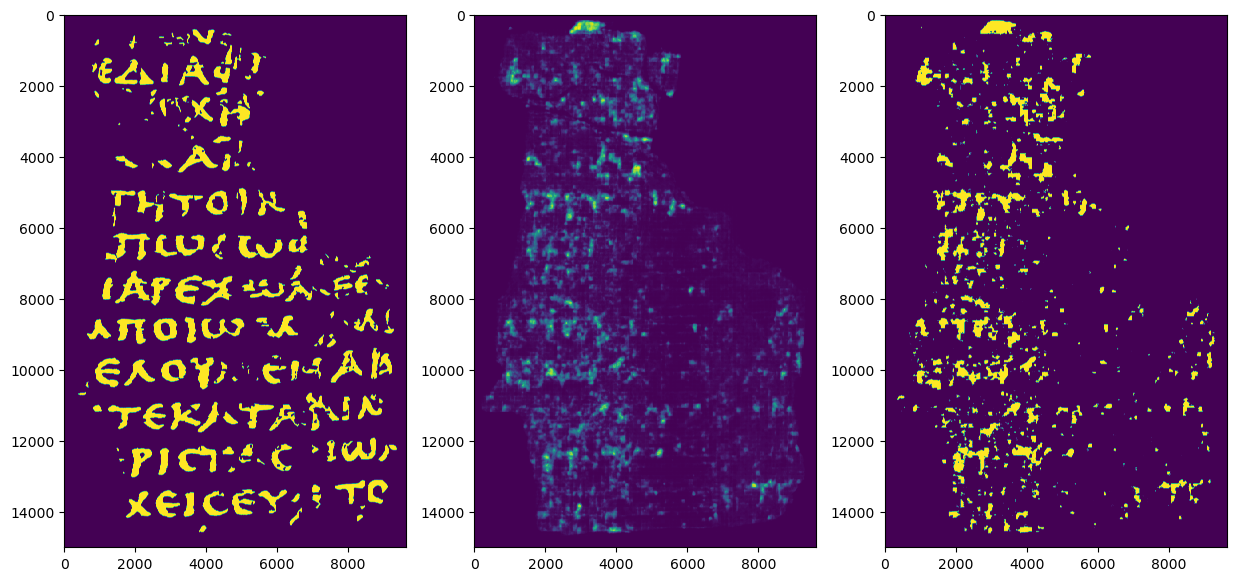

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.14737283e+08, 1.15706410e+07, 5.40380000e+06, 3.45253500e+06,
        2.34911900e+06, 1.68216400e+06, 1.31328500e+06, 9.89323000e+05,
        7.30683000e+05, 5.41051000e+05, 4.26229000e+05, 3.38030000e+05,
        2.87448000e+05, 2.25107000e+05, 1.72303000e+05, 1.29810000e+05,
        1.03160000e+05, 6.20870000e+04, 2.92720000e+04, 1.37260000e+04]),
 array([4.94243269e-09, 4.83832987e-02, 9.67665925e-02, 1.45149886e-01,
        1.93533180e-01, 2.41916474e-01, 2.90299768e-01, 3.38683062e-01,
        3.87066355e-01, 4.35449649e-01, 4.83832943e-01, 5.32216237e-01,
        5.80599531e-01, 6.28982824e-01, 6.77366118e-01, 7.25749412e-01,
        7.74132706e-01, 8.22516000e-01, 8.70899293e-01, 9.19282587e-01,
        9.67665881e-01]),
 <BarContainer object of 20 artists>)

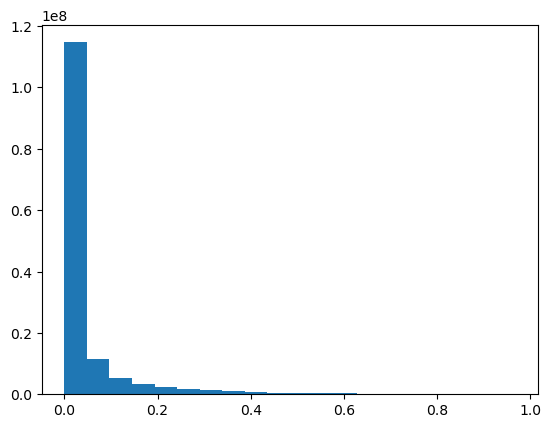

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000